## **Notebook Content**

Project: *Customer Prioritization Under Constraints*

File: 04_clustering_analysis.ipynb <br>
Author: Bryan Melvida

Purpose:
- Assess whether the scaled base behavioral features support defensible customer segmentation under finite execution capacity
- Identify customer groups only where behavioral differences are clear and visually separable
- Accept, reject, or constrain clustering outcomes based on behavioral evidence rather than algorithm output

Input: [`scaled_customer_features.parquet`](../data/preprocessed/scaled_customer_features.parquet) <br>

Output: [`customer_behavior_profile.parquet`](../data/final/customer_behavior_profile.parquet)<br>

<br>

---

<br>


In [ ]:
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names*")


import sys
sys.path.append('../')
import src.assessment_views as av
from src import plot_settings
from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

plot_settings.set()

In [2]:
scaled_features = pd.read_parquet('../data/preprocessed/scaled_customer_features.parquet', engine= 'pyarrow')

customer_features = pd.read_parquet('../data/preprocessed/customer_features.parquet', engine= 'pyarrow')
base_features = customer_features.set_index('CustomerID')

<br>

---

## **Clustering Decision Gate**

<ins>**Acceptance Rule**</ins>

>- A clustering solution is accepted only when visual separation, quantitative diagnostics, and behavioral interpretation align
>- No single signal is sufficient on its own
>- Failure in any one area results in rejection

<ins>**Clustering Evaluation Gate**</ins>
>- Clustering is optional and proceeds only if supported by evidence
>- The absence of defensible clusters is a valid outcome
>- This gate determines whether clustering proceeds beyond exploratory evaluation on the base feature space


<br>

---

## **Candidate Cluster Configurations**
Defines the bounded set of cluster counts evaluated

>**Clustering method:** K-Means

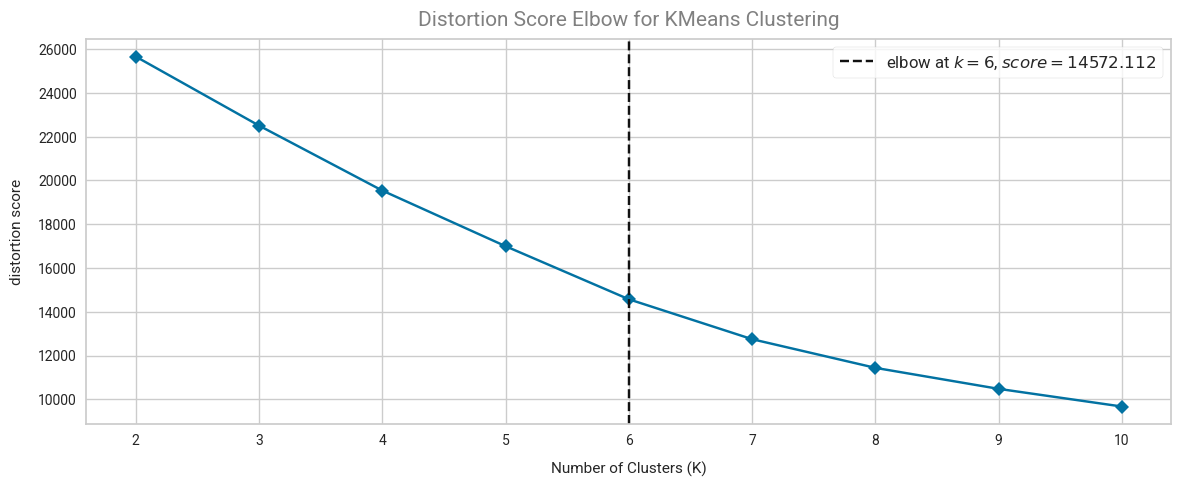

In [3]:
elbow_k = KMeans(init= 'k-means++', n_init= 10, max_iter= 100, random_state= 42)

fig, axs = plt.subplots(figsize= (14,5))

elbow_viz = KElbowVisualizer(estimator= elbow_k, timings= False)
elbow_viz.fit(scaled_features)
elbow_viz.finalize()

axs.xaxis.set_major_locator(plt.MaxNLocator(10))
axs.set_xlabel('Number of Clusters (K)')

plt.show()

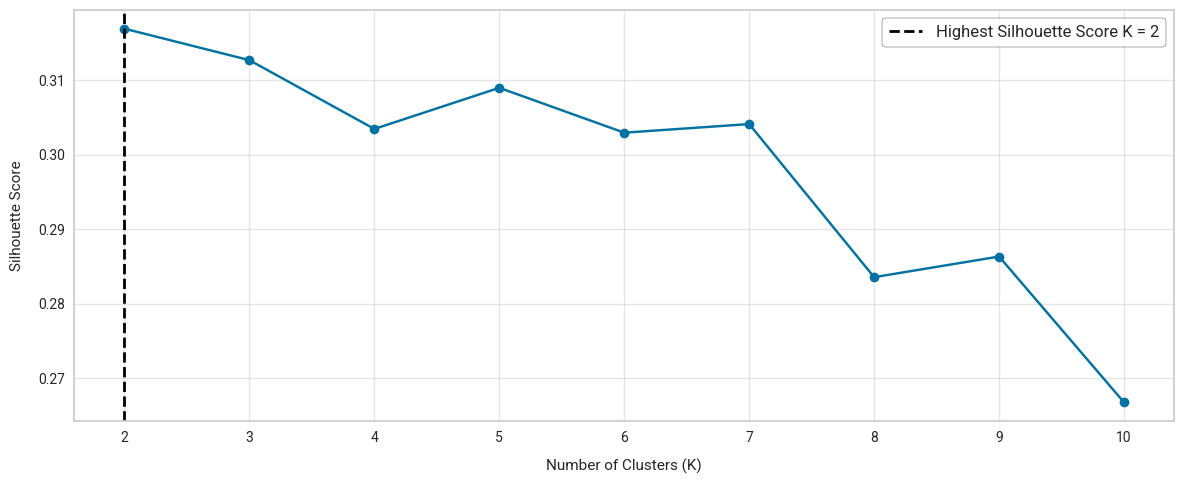

In [4]:
k_values = range(2,11)

sil_scores = []

for k in k_values:

    k_means = KMeans(n_clusters= k, init= 'k-means++', n_init= 10, max_iter= 100, random_state= 42)
    k_means.fit(scaled_features)
    labels = k_means.labels_

    score = silhouette_score(scaled_features, labels)
    sil_scores.append(score)


av.plot_silhouette_scores(cluster_range= k_values,
                          silhouette_scores= sil_scores,
                          xlabel= 'Number of Clusters (K)',
                          legend_label= 'Highest Silhouette Score K')
plt.show()

**Elbow and Silhouette Diagnostic Assessment**
>- Elbow diagnostics show gradual variance reduction with no clear breakpoint, indicating weak natural cluster structure
>- Silhouette scores peak at k=2 and decline as k increases, suggesting reduced separation and increasing overlap at higher k
>- Based on these signals, only a small set of low k values are carried forward for visual and behavioral assessment

<br>

---

## **Visual Separation Assessment**

Checks whether clusters form clearly separable groups

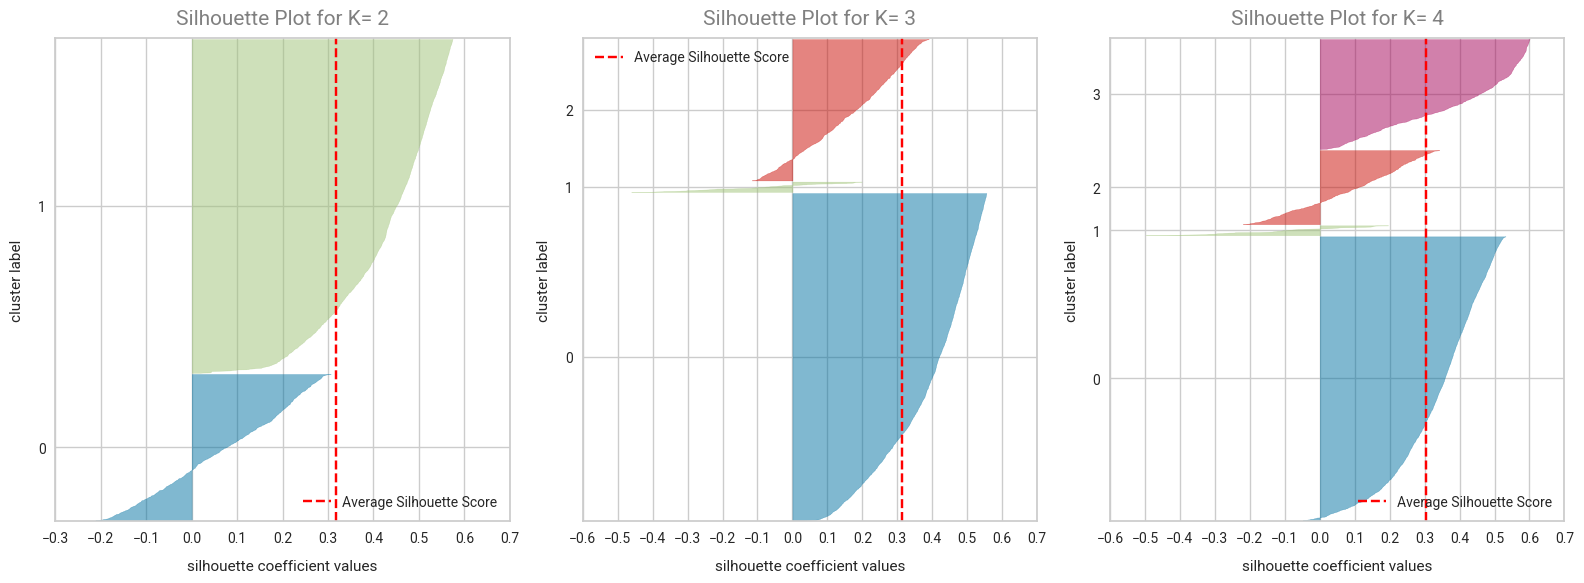

In [5]:
fig, axs = plt.subplots(ncols= 3, figsize = (16, 6))
axs = axs.flatten()

for idx, k in enumerate(range(2,5)):

    k_means = KMeans(n_clusters= k, init= 'k-means++', n_init= 10, max_iter= 100, random_state= 42)
    k_means.fit(scaled_features)

    sil_viz = SilhouetteVisualizer(k_means, ax= axs[idx], colors= 'yellowbrick', title= f'Silhouette Plot for K= {k}')
    sil_viz.fit(scaled_features)
    sil_viz.finalize()

plt.tight_layout()
plt.show()

>- Visual assessment using silhouette plots indicates weak natural clustering structure
>- A coarse split at k=2 shows the most defensible separation, while k=3 and k=4 introduce substantial overlap and negative silhouette values across clusters
>- These results indicate that increasing cluster count forces artificial boundaries rather than revealing distinct behavioral groups

<br>

---

## **Behavioral Coherence Assessment**

Checks whether clusters reflect clear and consistent behavioral differences

In [6]:
k = 2
kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=100, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

clustered_df = base_features.copy()
clustered_df["cluster"] = cluster_labels

# Behavioral differentiator features
behavioral_anchors = [
    "cancellation_rate",
    "product_repeat_rate",
    "avg_days_between_purchases",
    "avg_order_value",
    "is_seasonal"
]


# Summarized cluster behavioral differences
behavioral_summary= []

for cluster_id, group in clustered_df.groupby('cluster'):
    for feature in behavioral_anchors:
        q25 = group[feature].quantile(0.25)
        q50 = group[feature].quantile(0.50)
        q75 = group[feature].quantile(0.75)

        behavioral_summary.append({'cluster': cluster_id,
                                   'feature': feature,
                                   'median': round(q50, 3),
                                   'iqr': round(q75 - q25, 3)
                                   })
        
behavioral_summary_df = pd.DataFrame(behavioral_summary)

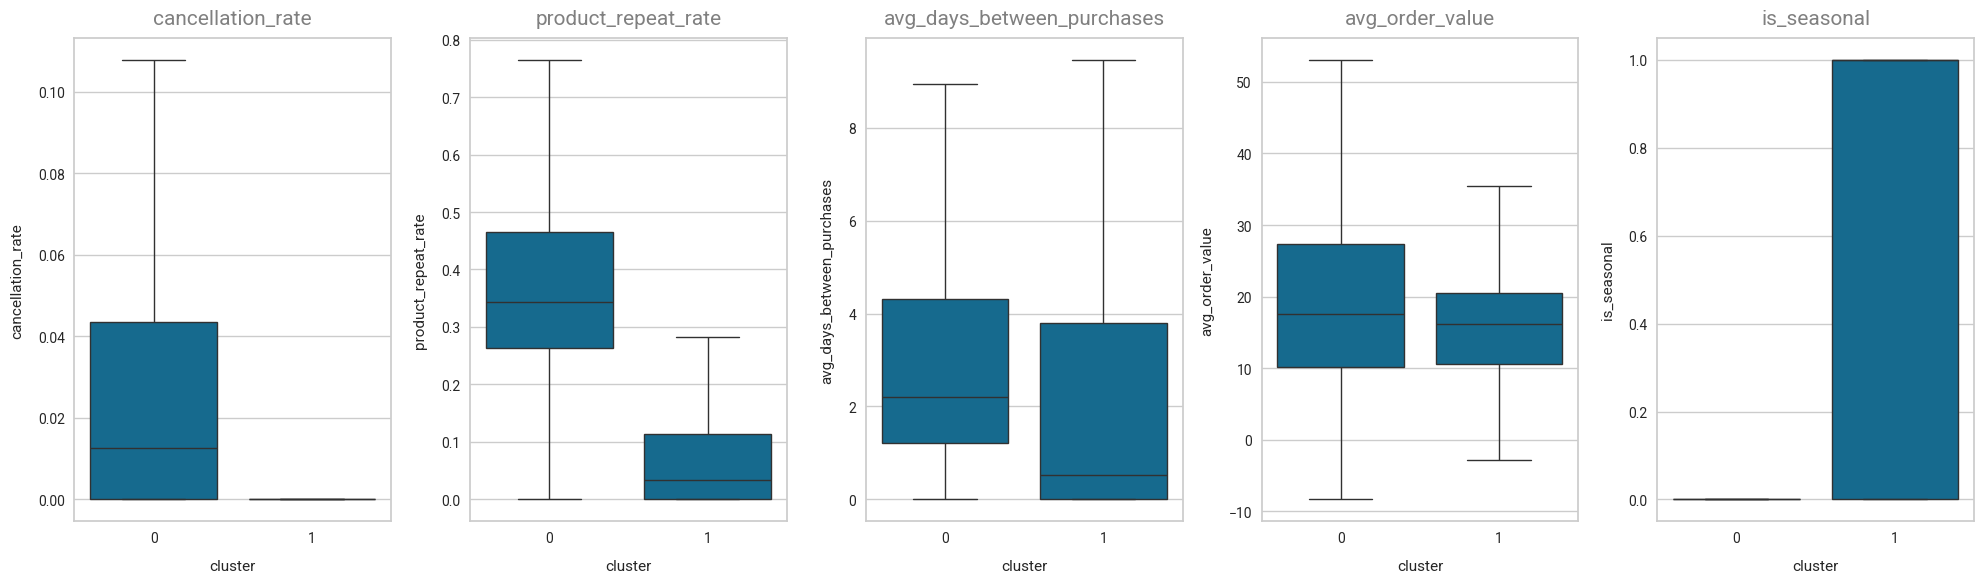

cluster,1,1,1,1,1
feature,cancellation_rate,product_repeat_rate,avg_days_between_purchases,avg_order_value,is_seasonal
median,0.0,0.033,0.52,16.111,1.0
iqr,0.0,0.113,3.792,10.007,1.0


cluster,0,0,0,0,0
feature,cancellation_rate,product_repeat_rate,avg_days_between_purchases,avg_order_value,is_seasonal
median,0.013,0.343,2.212,17.6,0.0
iqr,0.044,0.201,3.108,17.202,0.0


In [7]:
n_plots = len(behavioral_anchors)

fig, axes = plt.subplots(ncols=n_plots, figsize=(4 * n_plots, 6))

# Plot clusters variance comparison
for idx, feature in enumerate(behavioral_anchors):
    sns.boxplot(
        data=clustered_df,
        x="cluster",
        y=feature,
        ax=axes[idx],
        showfliers= False
    )
    axes[idx].set_title(f"{feature}")

plt.tight_layout()
plt.show()

# Display transposed behavioral summaries for clusters
display(
    behavioral_summary_df.loc[behavioral_summary_df['cluster'] == 1].set_index('cluster').T
    )

display(
    behavioral_summary_df.loc[behavioral_summary_df['cluster'] == 0].set_index('cluster').T
    )

<ins>**Assessment Result**</ins>

>- Behavioral coherence assessment shows that clustering does not produce internally consistent behavioral groups
>- While seasonality and cancellation behavior separate, core behavioral dimensions (purchase rhythm, repeat behavior, order value) show substantial overlap across clusters
>- Within clusters, customer behavior remains mixed across most dimensions
>- As a result, cluster assignments introduce material misclassification risk and reduce behavioral clarity rather than improve it

<br>

---

## **Cluster Decision**
Records the final decision on clustering outcomes

>- Clustering did not produce behaviorally coherent segments beyond a coarse split driven by seasonality and cancellation stability
>- Substantial overlap and within-cluster variability across other behavioral dimensions render cluster labels unreliable for downstream use
>- Cluster assignments are therefore rejected
>- Relevant behavioral signals (seasonality and cancellation stability) are retained as standalone categorical features

<br>

---

In [8]:
customer_behavior_profile = customer_features.copy()
customer_behavior_profile['is_seasonal_customer'] = np.where(customer_behavior_profile['is_seasonal'] == 1, 'Yes', 'No')
customer_behavior_profile['predictable_cancellation_behavior'] = np.where(customer_behavior_profile['cancellation_rate'] == 0,'Yes', 'No')

customer_behavior_profile.to_parquet('../data/final/customer_behavior_profile.parquet', engine= 'pyarrow')

## **End of Notebook** 
* Evaluated clustering as a candidate mechanism for customer differentiation under constrained execution capacity
* Assessed visual separation, behavioral coherence, and quantitative diagnostics across candidate cluster configurations
* Clustering rejected due to limited behavioral coherence and high misclassification risk, despite isolated signal separation
* Underlying behavioral signals are retained as standalone features
* Ready for downstream notebook: [`05_prioritization_analysis.ipynb`](../notebooks/05_prioritization_analysis.ipynb)